# Building and Optimising Neural Network Surrogates with $\texttt{gwbonsai}$

Author: Lucy M Thomas

Email: lmthomas@caltech.edu

Date: 3rd June 2025

This notebook was created for a tutorial called 'Public Code Packages to Visualise and Optimise Gravitational Wave Surrogate Models'. 

The tutorial is given as part of a workshop session on Scientific Machine Learning for Gravitational Wave Astronomy, ICERM, Brown University, on 3rd June 2025.

In [1]:
# Import useful packages
import numpy as np
import matplotlib.pyplot as plt
import sklearn

We consider a simple subspace of non-spinning binary black hole mergers ($\vec{\chi}_{1}=\vec{\chi}_{2}=0$). We restrict to mass ratios between $q=1$ and $q=2$.

Let's build a fit for the time-domain amplitude of the $(2,2)$-mode.

## Create and Align the Training Data

First, let's generate some training data for our fit. We'll use the $\texttt{NRSur7dq4}$ model to generate this training data.

In [2]:
# Let's first check that the installation of gwsurrogate was successful, and then download the surrogate model.
import gwsurrogate as gws
sur = gws.LoadSurrogate('NRSur7dq4') # This download might take a minute or two, depending on your internet connection speed.

/opt/anaconda3/envs/gwbonsai/lib/python3.11/site-packages/gwtools/const.py:52: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


lal.MSUN_SI != Msun
Loaded NRSur7dq4 model


Now we'll define functions to generate training data.

In [3]:
# define a simplified interface to the NRSur7dq4 model
def NRSur7dq4_22_nonspinning(q, dt=0.1):
    """ Simplified inferface to NRSur7dq4 to get the (2,2) mode amplitude for nonspinning systems.

      INPUT
      =====
      q  -- mass ratio
      dt -- timestep size, Units of M"""

    chiA  = [0.0, 0.0, 0.0]        # dimensionless spin of the heavier BH
    chiB  = [0.0, 0.0, 0.0]        # dimensionless spin of the lighter BH
    f_low = 0.0065               # initial frequency in units of 1/M
    f_ref = f_low                  # reference frequecny (1/M) spins defined at

    times, h, dyn = sur(q, chiA, chiB, dt=dt, f_low=f_low, f_ref=f_ref)

    return times, np.abs(h[(2,2)])

def training_set_generator(N,dt=0.1,verbose=False):
    """Generate N training samples from q in [1,2]"""
    qs = np.linspace(1.0,2.0,N)
    training_data = []
    for q in qs:
        t,h = NRSur7dq4_22_nonspinning(q,dt=dt)
        training_data.append(h)
        if verbose:
            print('length of h is %i'%len(h))
    return qs, training_data

We'll start with 11 points between $q=1$ and $q=2$, and 11 points between $\chi_{1z}\in[0.,0.8]$, and start by visualising the training data.

In [4]:
num_train_samples = 11

q_train, train_data = training_set_generator(num_train_samples, verbose=True)

length of h is 22900
length of h is 22942
length of h is 23050
length of h is 23209
length of h is 23404
length of h is 23638
length of h is 23903
length of h is 24185
length of h is 24480
length of h is 24790
length of h is 25117


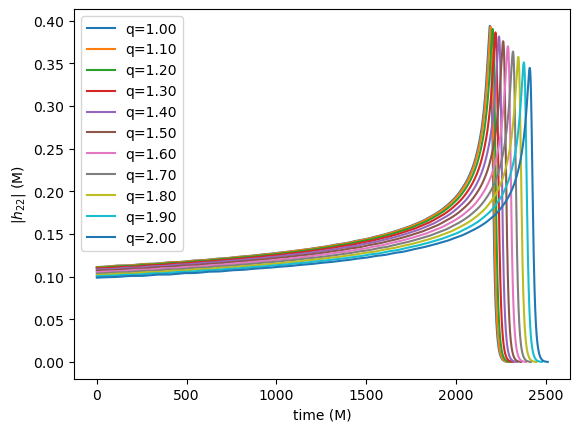

In [5]:
for i in range(num_train_samples):
    times = 0.1 * np.arange(len(train_data[i]))
    plt.plot(times,train_data[i], label='q=%.2f'%q_train[i])
plt.xlabel('time (M)')
plt.ylabel('$|h_{22}|$ (M)')
plt.legend()

In [6]:
def common_time_grid(training_data,dt=0.1):
    """
    INPUT
    =====
    training_data: set of training waveforms 
    
    OUTPUT
    ======
    training data as a numpy array, padding with zeros as 
    necessary such that all waveforms are of the same length"""
    
    longest_waveform = 0
    for h in training_data:
        length = len(h)
        if length > longest_waveform:
            longest_waveform = length
            
    print("longest waveform size = %i"%longest_waveform)
        
    padded_training_data = []
    for h in training_data:
        nZeros = longest_waveform - len(h)
        h_pad = np.append(h, np.zeros(nZeros))
        padded_training_data.append(h_pad)
        
    times = np.arange(longest_waveform)*dt
    
    padded_training_data = np.vstack(padded_training_data).transpose()
    
    return times, padded_training_data

times, train_data = common_time_grid(train_data)

longest waveform size = 25117


In [7]:
def get_peak(t, h):
  """Get argument and values of t and h at maximum value of |h| on a discrete grid. """
  arg = np.argmax(np.abs(h))
  return [arg, t[arg], h[arg]]

def get_peaks(t,training_set):
    """ Find the index of each waveform's peak in the entire training set. """
    time_peak_arg = []
    for i in range(num_train_samples):
        [arg, t_peak, h_peak] = get_peak(times,training_set[:,i]) # i^th training sample
        time_peak_arg.append(arg)
        print("Waveform %i with t_peak = %f"%(i,t_peak))
    print(time_peak_arg)
    return time_peak_arg

def align_peaks(times, training_set):
    """ Peak align a set of waveforms. The shortest waveform is used as the reference
    one."""
    
    time_peak_arg = get_peaks(times,training_set)
    
    min_arg = min(time_peak_arg)
    aligned_training_set=[]
    for i in range(num_train_samples):
        offset = time_peak_arg[i] - min_arg
        print("offset value of %i"%offset)
        h_aligned = training_set[offset:,i]
        aligned_training_set.append(h_aligned)
        
    t, training_data_aligned = common_time_grid(aligned_training_set)
    return training_data_aligned

train_data_aligned = align_peaks(times, train_data)

Waveform 0 with t_peak = 2189.700000
Waveform 1 with t_peak = 2193.900000
Waveform 2 with t_peak = 2204.700000
Waveform 3 with t_peak = 2220.500000
Waveform 4 with t_peak = 2240.100000
Waveform 5 with t_peak = 2263.400000
Waveform 6 with t_peak = 2289.900000
Waveform 7 with t_peak = 2318.000000
Waveform 8 with t_peak = 2347.500000
Waveform 9 with t_peak = 2378.500000
Waveform 10 with t_peak = 2411.200000
[21897, 21939, 22047, 22205, 22401, 22634, 22899, 23180, 23475, 23785, 24112]
offset value of 0
offset value of 42
offset value of 150
offset value of 308
offset value of 504
offset value of 737
offset value of 1002
offset value of 1283
offset value of 1578
offset value of 1888
offset value of 2215
longest waveform size = 25117


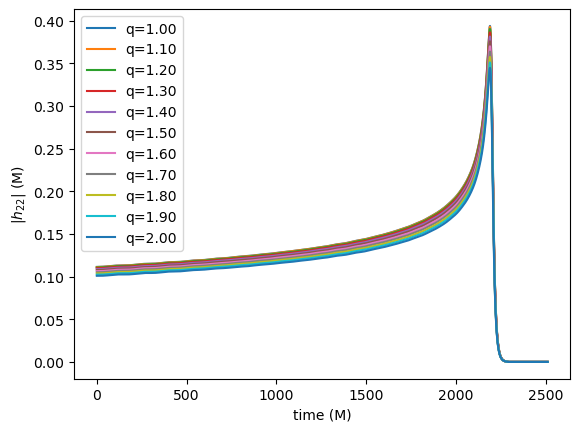

In [8]:
for i in range(num_train_samples):
    plt.plot(times, train_data_aligned[:,i], label='q=%.2f'%q_train[i])
plt.xlabel('time (M)')
plt.ylabel('$|h_{22}|$ (M)')
plt.legend()

For the actual model, we'll probably need more than 11 training points, so let's generate 401. This might take a few seconds.

In [12]:
num_train_samples = 401
q, data = training_set_generator(num_train_samples, verbose=False)
times, data = common_time_grid(data)
data_aligned = align_peaks(times, data)

longest waveform size = 25117
Waveform 0 with t_peak = 2189.700000
Waveform 1 with t_peak = 2189.700000
Waveform 2 with t_peak = 2189.700000
Waveform 3 with t_peak = 2189.700000
Waveform 4 with t_peak = 2189.700000
Waveform 5 with t_peak = 2189.800000
Waveform 6 with t_peak = 2189.800000
Waveform 7 with t_peak = 2189.800000
Waveform 8 with t_peak = 2189.900000
Waveform 9 with t_peak = 2189.900000
Waveform 10 with t_peak = 2190.000000
Waveform 11 with t_peak = 2190.000000
Waveform 12 with t_peak = 2190.100000
Waveform 13 with t_peak = 2190.200000
Waveform 14 with t_peak = 2190.300000
Waveform 15 with t_peak = 2190.300000
Waveform 16 with t_peak = 2190.400000
Waveform 17 with t_peak = 2190.500000
Waveform 18 with t_peak = 2190.600000
Waveform 19 with t_peak = 2190.700000
Waveform 20 with t_peak = 2190.800000
Waveform 21 with t_peak = 2190.900000
Waveform 22 with t_peak = 2191.000000
Waveform 23 with t_peak = 2191.200000
Waveform 24 with t_peak = 2191.300000
Waveform 25 with t_peak = 2191

We'll find it useful to split this data set into a training, validation and test set for when we come to train our model.

In [13]:
q_train, q_validation, train_data, validation_data = sklearn.model_selection.train_test_split(q, data_aligned.T, random_state=0,test_size=0.4)
q_test, q_validation, test_data, validation_data = sklearn.model_selection.train_test_split(q_validation, validation_data, random_state=0,test_size=0.5)
print('Number of training samples: %i'%len(q_train))
print('Number of validation samples: %i'%len(q_validation))
print('Number of test samples: %i'%len(q_test))
q_train = q_train.reshape(q_train.shape[0], 1)
q_validation = q_validation.reshape(q_validation.shape[0], 1)
q_test = q_test.reshape(q_test.shape[0], 1)


Number of training samples: 240
Number of validation samples: 81
Number of test samples: 80


## Create the Bases and Empirical Interpolant

In [14]:
import rompy as rp

In [15]:
integration = rp.Integration([times[0], times[-1]], num=len(times), rule='trapezoidal')
rb = rp.ReducedBasis(integration)
rb.make(train_data, 0, 1e-10, verbose=True)
# We could try reducing/increasing this tolerance to see how it affects the reduced basis size.
print("Reduced basis dimension: %i"%rb.size)
eim = rp.EmpiricalInterpolant(rb.basis, verbose=True)
print("Empirical interpolant completed.")
print("relative compression ratio: %.2f"%(float((num_train_samples*len(times))/(rb.size*eim.size))))

('\nStep', '\t', 'Error')
(1, '\t', 50.862012490479195)
(2, '\t', 0.0022082187510648055)
(3, '\t', 5.351988093593718e-05)
(4, '\t', 5.48585690296477e-06)
(5, '\t', 2.8421240472198406e-08)
(6, '\t', 9.873488693301624e-09)
(7, '\t', 6.00570615461038e-09)
(8, '\t', 3.397047976250178e-09)
(9, '\t', 1.2941114846398705e-10)
(10, '\t', 2.1614710021822248e-11)
Reduced basis dimension: 9
('\nStep', '\t', 'Nodes')
(1, '\t', 21897)
(2, '\t', 17723)
(3, '\t', 22087)
(4, '\t', 22028)
(5, '\t', 22901)
(6, '\t', 22900)
(7, '\t', 22313)
(8, '\t', 21975)
(9, '\t', 22064)
Empirical interpolant completed.
relative compression ratio: 124344.65


In [16]:
eim.make_data(validation_data)
val_eim_data = eim.data
eim.make_data(test_data)
test_eim_data = eim.data
eim.make_data(train_data)
train_eim_data = eim.data
train_eim_data = train_eim_data.reshape(train_eim_data.shape[1], train_eim_data.shape[0])
val_eim_data = val_eim_data.reshape(val_eim_data.shape[1], val_eim_data.shape[0])
test_eim_data = test_eim_data.reshape(test_eim_data.shape[1], test_eim_data.shape[0])


## Create A Simple Neural Network Fit

We'll make a simple, sequential, fully connected multi-layer perceptron (MLP) to model the parametric fits of the EIM nodes across the parameter space of $q\in[1,2]$.

In [17]:
import sys
sys.path.append('/Users/lucythomas/ResearchProjects/gwbonsai/')
import gwbonsai as gb
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Dropout
from keras.optimizers import Adam
import tensorflow
tensorflow.random.set_seed(123456)
from contextlib import redirect_stdout

We'll compile a simple MLP to do the fit, and train it to see how it looks.

In [18]:
file_prefix = '/Users/lucythomas/ResearchProjects/ICERM/' # Where to save the model
input_shape = 1 # We have only one input, the mass ratio q
output_shape = 9 # The number of EIM nodes
num_hidden_layers = 4 # Number of hidden layers in the neural network
nodes_per_layer = 10 # Number of nodes per hidden layer
activation = 'relu' # Activation function for the hidden layers
learning_rate = 1e-3 # Learning rate for the optimizer


In [19]:
model = Sequential()
model.add(InputLayer(shape=(input_shape,)))

for layer in range(num_hidden_layers):
    model.add(Dense(nodes_per_layer, activation=activation))
    
model.add(Dense(output_shape, activation='linear'))

model.compile(
    # Optimization algorithm, specify learning rate
    optimizer=Adam(learning_rate=learning_rate),
    # Loss function for a binary classifier
    loss='mean_squared_error',
    # Diagnostic quantities
    #metrics=['mean_squared_error']
    )
# Saving summary of compiled model to model_summary.txt.
with open(file_prefix+'model_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 9)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 449 (1.75 KB)

 Trainable params: 449 (1.75 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(q_train, train_eim_data,epochs=100, batch_size=16, validation_data=(q_validation, val_eim_data), verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0462 - val_loss: 0.0417
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0401 - val_loss: 0.0367
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0351 - val_loss: 0.0313
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0297 - val_loss: 0.0260
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0247 - val_loss: 0.0221
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0213 - val_loss: 0.0200
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0196 - val_loss: 0.0189
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0186 - val_loss: 0.0183
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0182 - val_loss: 0.0181
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0180 - val_loss: 0.0180
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0179 - val_loss: 0.0179
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0

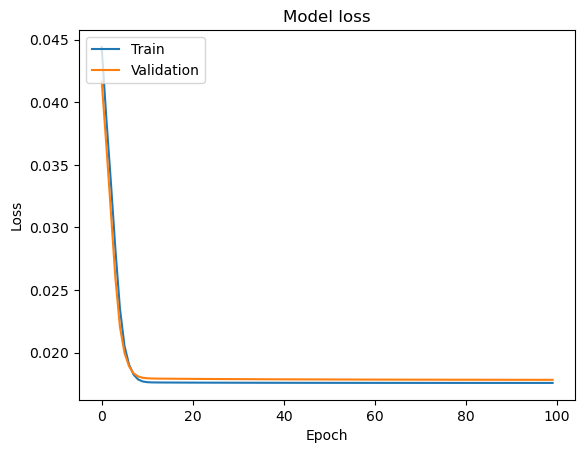

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Training history looks okay, a small amount of fitting after ~10 epochs but not too bad. Let's evaluate the surrogate model on the test set and plot the results. We'll plot a random one of the test waveform amplitudes to get an idea of how we're doing.

In [22]:
nodes = model.predict(q_test)
predicted_test_data = np.dot(nodes, eim.B)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/var/folders/s7/ppvg5_4n3rb1jwlrypfbl4g00000gn/T/ipykernel_14295/20075056.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(times, predicted_test_data[26,:], label='q=%.2f (predicted)'%q_test[26])
/var/folders/s7/ppvg5_4n3rb1jwlrypfbl4g00000gn/T/ipykernel_14295/20075056.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(times, test_data[26,:], label='q=%.2f (true)'%q_test[26])


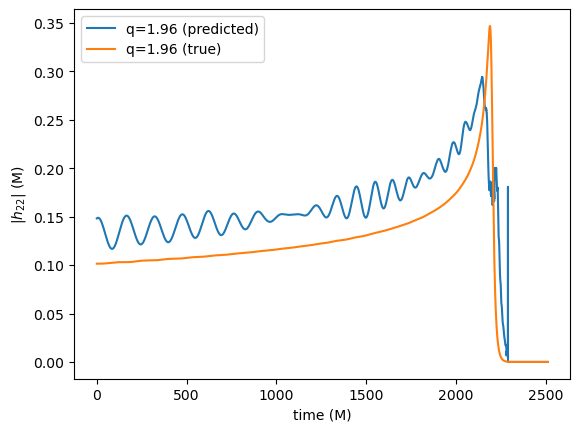

In [23]:
plt.plot(times, predicted_test_data[26,:], label='q=%.2f (predicted)'%q_test[26])
plt.plot(times, test_data[26,:], label='q=%.2f (true)'%q_test[26])
plt.xlabel('time (M)')
plt.ylabel('$|h_{22}|$ (M)')
plt.legend();

Gross, looks like our model seriously needs some work! But how do we achieve a better fit? 

Is it with more layers? More training data? A different activaton function? A bit of everything?

How do we know (without lots of prior experience of this problem) which hyperparameters to change and which to leave?

## Motivation for Systematic Optimisation

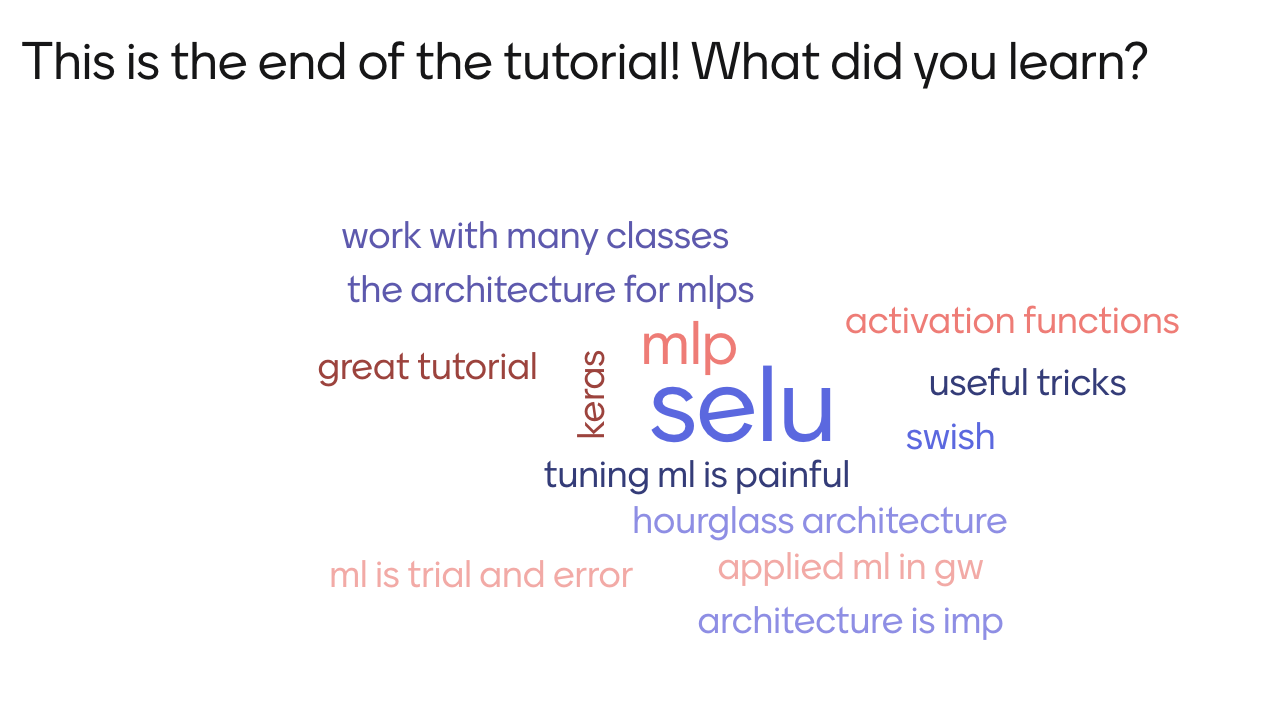

In [24]:
from PIL import Image
from IPython.display import display
img = Image.open('mentimeter_screenshot.png')
display(img)

Let's look back at the metimeter from the end of Melissa's session yesterday.

>'tuning ml is painful'...

>'ml is trial and error'...

>'architecture is important'...

What if there was a way we could try and simplify all this? To optimise the network and its training data in a more systematic way, to try and make sure we're getting the best surrogate we possibly can with a neural network?

Enter: `gwbonsai` (Building and Optimising Neural Surrogates for Astrophysical Inference). 

It's a helper package that provides routines for systematically optimising the training of neural network gravitatioanl wave surrogate models. It's available at this Git repo [link](https://github.com/lucymthomas/gwbonsai/tree/main). 

The package is stll being actively developed, so if you're a person who would benefit from this and want to see features that don't exist yet, please let me know! 

It leverages the power of `Optuna` for optimising the hyperparameters of the model, and then optimises the amount and distribution of training data required to ahcieve a good fit.

Practically, we found that for most surrogate-building applications, optimising all the architecture (not to mention the training dataset) all at once was prohibively expensive. Therefore we split the problem up into sections:
    
1. Optimise functional hyperparameter (network non-linear behaviour)
2. Optimise network size and shape parameters (avoids overfitting)
3. Optimise training dataset size and distribtuion (ensures good coverage of the parameter space)


In the remainder of this tutorial, we will go over these three steps in details for our (2,2)-mode amplitude model, and hopefully achieve a more convincing surrogate at the end!

## A Quick Aside: How Does the Hyperparameter Optimisation Work?

The default hyperparameter optimisation used in `Optuna` is called a `TPE sampler`, which stands for `Tree-structured Parzen Estimator`.
The mathematical idea behind the TPE sampler is based on Bayesian optimisation, and simultaneously models the distribution of 'good' points in hyperspace, and 'bad' ones.


Let $x$ be the value of a hyperparameter

Let $y$ be the value of the loss function that hyperparameter achieves

We are trying to find the value of $x$ across the space that minimises $y$

TPE key idea:

model $P(x|y)$ rather than $P(y|x)$

Throughout optimisation, we model two distributions:

$P(x | y > y*) = P(x | bad)$

$P(x | y =< y*) = P(x | good)$

New samples are proposed by maximising the expected improvement:

$EI = P(x | y =< y*) / P(x | y > y*)$


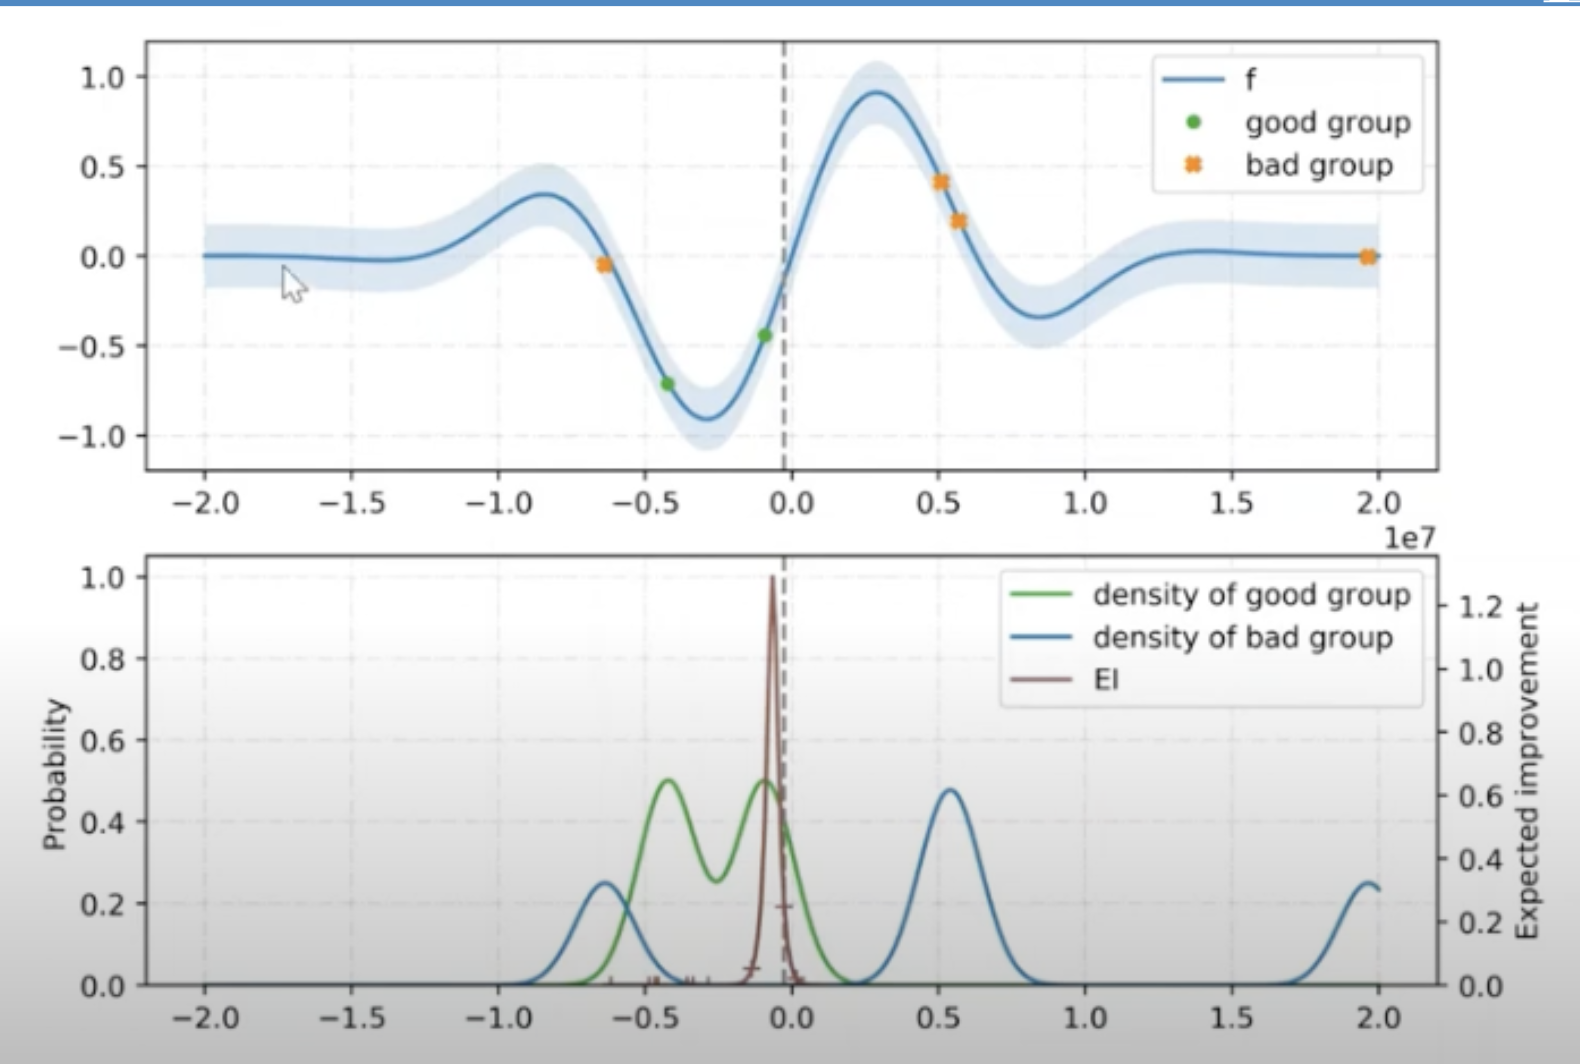

In [25]:
img = Image.open('TPE1.png')
display(img)

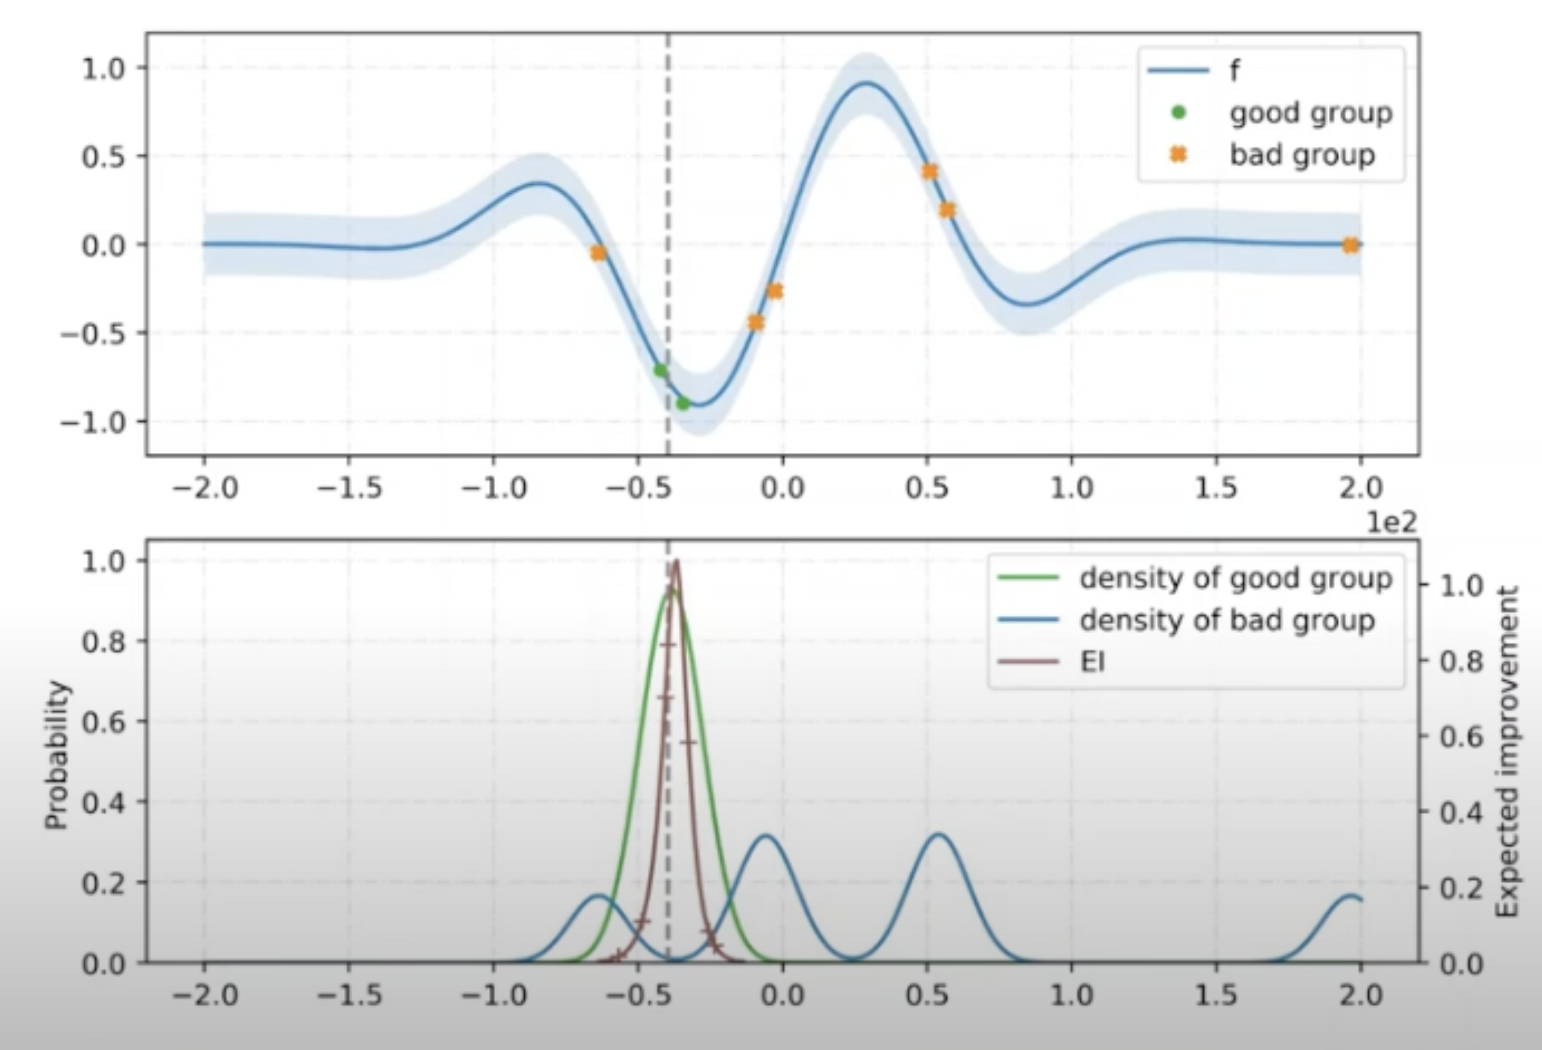

In [26]:
img = Image.open('TPE2.png')
display(img)

## Optimising Functional Hyperparameters

In [27]:
functional_options_dict = {
    'activation': ['relu', 'tanh', 'sigmoid'],
    'weight_init': ['glorot_uniform'], #['glorot_uniform', 'HeUniform', 'HeNormal'],
    'learning_rate': [1e-4, 1e-3, 1e-2],
    'optimiser': ['Adam','Adamax','Nadam','Ftrl', 'SGD', 'RMSprop'],
    'normalisation': [0] #[0, 1], # Whether to use batch normalization
}

fixed_dict = {
    'nodes_per_layer': 10,
    'num_hidden_layers': 4,
    'dropout': 1.0, # 1 for dropout layer, 0 for no dropout
    'dropout_rate': 0.2, # dropout rate
    'batch_size':16, #[8, 16, 32]
    'num_epochs': 100,
}
input_dim = 1
output_dim = 9

In [30]:
from optuna.samplers import TPESampler
import optuna
from functools import partial
sampler = TPESampler(seed=123456)
from gwbonsai.optimise_hyper.optimise_functional_tensorflow import functional_objective

objective_partial = partial(functional_objective, input_dim=input_dim, output_dim=output_dim, functional_options_dict=functional_options_dict, fixed_dict=fixed_dict, x_train=q_train, train_eim_data=train_eim_data, x_validation=q_validation, val_eim_data=val_eim_data, x_test=q_test, test_eim_data=test_eim_data, eim=eim)
study = optuna.create_study(direction='minimize',sampler=sampler)
study.optimize(objective_partial, n_trials=50)

print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
        
best_params = trial.params
np.save('best_functional_hyper.npy', best_params)


[I 2025-06-03 09:44:16,323] A new study created in memory with name: no-name-d0c004e2-2aa4-4e64-a7de-8367b4b3576e
/opt/anaconda3/envs/gwbonsai/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-06-03 09:44:19,720] Trial 0 finished with value: 0.12030945412977308 and parameters: {'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 3, 'optimiser': 'Ftrl', 'learning_rate': 0.001}. Best is trial 0 with value: 0.12030945412977308.


Params:
{'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 3, 'optimiser': 'Ftrl', 'learning_rate': 0.001}
Mean Absolute Error: 0.12031
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x3289d87c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-06-03 09:44:22,989] Trial 1 finished with value: 0.13587815781956594 and parameters: {'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 0, 'optimiser': 'Ftrl', 'learning_rate': 0.0001}. Best is trial 0 with value: 0.12030945412977308.


Params:
{'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 0, 'optimiser': 'Ftrl', 'learning_rate': 0.0001}
Mean Absolute Error: 0.13588
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


[I 2025-06-03 09:44:26,222] Trial 2 finished with value: 0.09161238617017345 and parameters: {'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 3, 'optimiser': 'Adam', 'learning_rate': 0.01}. Best is trial 2 with value: 0.09161238617017345.


Params:
{'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 3, 'optimiser': 'Adam', 'learning_rate': 0.01}
Mean Absolute Error: 0.09161
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


[I 2025-06-03 09:44:29,935] Trial 3 finished with value: 0.09179996733794099 and parameters: {'activation': 'sigmoid', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Nadam', 'learning_rate': 0.01}. Best is trial 2 with value: 0.09161238617017345.


Params:
{'activation': 'sigmoid', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Nadam', 'learning_rate': 0.01}
Mean Absolute Error: 0.09180
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-06-03 09:44:33,052] Trial 4 finished with value: 0.09121980176703985 and parameters: {'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Adamax', 'learning_rate': 0.01}. Best is trial 4 with value: 0.09121980176703985.


Params:
{'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Adamax', 'learning_rate': 0.01}
Mean Absolute Error: 0.09122
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


[I 2025-06-03 09:44:36,250] Trial 5 finished with value: 0.09150242819111118 and parameters: {'activation': 'sigmoid', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Adamax', 'learning_rate': 0.001}. Best is trial 4 with value: 0.09121980176703985.


Params:
{'activation': 'sigmoid', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Adamax', 'learning_rate': 0.001}
Mean Absolute Error: 0.09150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 


[I 2025-06-03 09:44:38,887] Trial 6 finished with value: 0.09453289600711708 and parameters: {'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'SGD', 'learning_rate': 0.001}. Best is trial 4 with value: 0.09121980176703985.


Params:
{'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'SGD', 'learning_rate': 0.001}
Mean Absolute Error: 0.09453
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


[I 2025-06-03 09:44:41,952] Trial 7 finished with value: 0.09153388638422284 and parameters: {'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'RMSprop', 'learning_rate': 0.001}. Best is trial 4 with value: 0.09121980176703985.


Params:
{'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'RMSprop', 'learning_rate': 0.001}
Mean Absolute Error: 0.09153
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


[I 2025-06-03 09:44:44,883] Trial 8 finished with value: 0.09151348392450921 and parameters: {'activation': 'sigmoid', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 3, 'optimiser': 'RMSprop', 'learning_rate': 0.01}. Best is trial 4 with value: 0.09121980176703985.


Params:
{'activation': 'sigmoid', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 3, 'optimiser': 'RMSprop', 'learning_rate': 0.01}
Mean Absolute Error: 0.09151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


[I 2025-06-03 09:44:48,085] Trial 9 finished with value: 0.09165239880869432 and parameters: {'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 0, 'optimiser': 'Adam', 'learning_rate': 0.001}. Best is trial 4 with value: 0.09121980176703985.


Params:
{'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 0, 'optimiser': 'Adam', 'learning_rate': 0.001}
Mean Absolute Error: 0.09165
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


[I 2025-06-03 09:44:51,234] Trial 10 finished with value: 0.09232299546871223 and parameters: {'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 2, 'optimiser': 'Adamax', 'learning_rate': 0.0001}. Best is trial 4 with value: 0.09121980176703985.


Params:
{'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 2, 'optimiser': 'Adamax', 'learning_rate': 0.0001}
Mean Absolute Error: 0.09232
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 


[I 2025-06-03 09:44:54,391] Trial 11 finished with value: 0.09248590747434057 and parameters: {'activation': 'sigmoid', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 2, 'optimiser': 'Adamax', 'learning_rate': 0.01}. Best is trial 4 with value: 0.09121980176703985.


Params:
{'activation': 'sigmoid', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 2, 'optimiser': 'Adamax', 'learning_rate': 0.01}
Mean Absolute Error: 0.09249
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-06-03 09:44:57,545] Trial 12 finished with value: 0.0915126502447283 and parameters: {'activation': 'sigmoid', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Adamax', 'learning_rate': 0.001}. Best is trial 4 with value: 0.09121980176703985.


Params:
{'activation': 'sigmoid', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Adamax', 'learning_rate': 0.001}
Mean Absolute Error: 0.09151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


[I 2025-06-03 09:45:00,867] Trial 13 finished with value: 0.09158675932072885 and parameters: {'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 0, 'optimiser': 'Adamax', 'learning_rate': 0.01}. Best is trial 4 with value: 0.09121980176703985.


Params:
{'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 0, 'optimiser': 'Adamax', 'learning_rate': 0.01}
Mean Absolute Error: 0.09159
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-06-03 09:45:04,064] Trial 14 finished with value: 0.10180385385371518 and parameters: {'activation': 'sigmoid', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 2, 'optimiser': 'Adamax', 'learning_rate': 0.0001}. Best is trial 4 with value: 0.09121980176703985.


Params:
{'activation': 'sigmoid', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 2, 'optimiser': 'Adamax', 'learning_rate': 0.0001}
Mean Absolute Error: 0.10180
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-06-03 09:45:07,820] Trial 15 finished with value: 0.09123504765120745 and parameters: {'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Nadam', 'learning_rate': 0.001}. Best is trial 4 with value: 0.09121980176703985.


Params:
{'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Nadam', 'learning_rate': 0.001}
Mean Absolute Error: 0.09124
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


[I 2025-06-03 09:45:11,516] Trial 16 finished with value: 0.09170770614135129 and parameters: {'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 2, 'optimiser': 'Nadam', 'learning_rate': 0.01}. Best is trial 4 with value: 0.09121980176703985.


Params:
{'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 2, 'optimiser': 'Nadam', 'learning_rate': 0.01}
Mean Absolute Error: 0.09171
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


[I 2025-06-03 09:45:15,105] Trial 17 finished with value: 0.09160090685475301 and parameters: {'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 0, 'optimiser': 'Nadam', 'learning_rate': 0.01}. Best is trial 4 with value: 0.09121980176703985.


Params:
{'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 0, 'optimiser': 'Nadam', 'learning_rate': 0.01}
Mean Absolute Error: 0.09160
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


[I 2025-06-03 09:45:17,850] Trial 18 finished with value: 0.09186322535803856 and parameters: {'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'SGD', 'learning_rate': 0.001}. Best is trial 4 with value: 0.09121980176703985.


Params:
{'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'SGD', 'learning_rate': 0.001}
Mean Absolute Error: 0.09186
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-06-03 09:45:21,415] Trial 19 finished with value: 0.09190089582570113 and parameters: {'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 2, 'optimiser': 'Nadam', 'learning_rate': 0.0001}. Best is trial 4 with value: 0.09121980176703985.


Params:
{'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 2, 'optimiser': 'Nadam', 'learning_rate': 0.0001}
Mean Absolute Error: 0.09190
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-06-03 09:45:25,003] Trial 20 finished with value: 0.09157639726373257 and parameters: {'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 0, 'optimiser': 'Nadam', 'learning_rate': 0.01}. Best is trial 4 with value: 0.09121980176703985.


Params:
{'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 0, 'optimiser': 'Nadam', 'learning_rate': 0.01}
Mean Absolute Error: 0.09158
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-06-03 09:45:28,049] Trial 21 finished with value: 0.0914987682977672 and parameters: {'activation': 'sigmoid', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Adamax', 'learning_rate': 0.001}. Best is trial 4 with value: 0.09121980176703985.


Params:
{'activation': 'sigmoid', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Adamax', 'learning_rate': 0.001}
Mean Absolute Error: 0.09150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 


[I 2025-06-03 09:45:32,062] Trial 22 finished with value: 0.09148185120105383 and parameters: {'activation': 'sigmoid', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Adamax', 'learning_rate': 0.001}. Best is trial 4 with value: 0.09121980176703985.


Params:
{'activation': 'sigmoid', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Adamax', 'learning_rate': 0.001}
Mean Absolute Error: 0.09148
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


[I 2025-06-03 09:45:35,494] Trial 23 finished with value: 0.09115394947014874 and parameters: {'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Adamax', 'learning_rate': 0.001}. Best is trial 23 with value: 0.09115394947014874.


Params:
{'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Adamax', 'learning_rate': 0.001}
Mean Absolute Error: 0.09115
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-06-03 09:45:40,184] Trial 24 finished with value: 0.09133051336998868 and parameters: {'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Adam', 'learning_rate': 0.001}. Best is trial 23 with value: 0.09115394947014874.


Params:
{'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Adam', 'learning_rate': 0.001}
Mean Absolute Error: 0.09133
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-06-03 09:45:43,428] Trial 25 finished with value: 0.12030698640961734 and parameters: {'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 2, 'optimiser': 'Ftrl', 'learning_rate': 0.001}. Best is trial 23 with value: 0.09115394947014874.


Params:
{'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 2, 'optimiser': 'Ftrl', 'learning_rate': 0.001}
Mean Absolute Error: 0.12031
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-06-03 09:45:46,120] Trial 26 finished with value: 0.11755243712563476 and parameters: {'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'SGD', 'learning_rate': 0.001}. Best is trial 23 with value: 0.09115394947014874.


Params:
{'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'SGD', 'learning_rate': 0.001}
Mean Absolute Error: 0.11755
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-06-03 09:45:48,990] Trial 27 finished with value: 0.09155606929086073 and parameters: {'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 0, 'optimiser': 'RMSprop', 'learning_rate': 0.001}. Best is trial 23 with value: 0.09115394947014874.


Params:
{'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 0, 'optimiser': 'RMSprop', 'learning_rate': 0.001}
Mean Absolute Error: 0.09156
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


[I 2025-06-03 09:45:52,534] Trial 28 finished with value: 0.09207656771758285 and parameters: {'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Nadam', 'learning_rate': 0.0001}. Best is trial 23 with value: 0.09115394947014874.


Params:
{'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Nadam', 'learning_rate': 0.0001}
Mean Absolute Error: 0.09208
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


[I 2025-06-03 09:45:55,719] Trial 29 finished with value: 0.09150266240951088 and parameters: {'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 2, 'optimiser': 'Ftrl', 'learning_rate': 0.01}. Best is trial 23 with value: 0.09115394947014874.


Params:
{'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 2, 'optimiser': 'Ftrl', 'learning_rate': 0.01}
Mean Absolute Error: 0.09150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


[I 2025-06-03 09:45:58,692] Trial 30 finished with value: 0.09138296457673686 and parameters: {'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 0, 'optimiser': 'Adamax', 'learning_rate': 0.001}. Best is trial 23 with value: 0.09115394947014874.


Params:
{'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 0, 'optimiser': 'Adamax', 'learning_rate': 0.001}
Mean Absolute Error: 0.09138
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-06-03 09:46:02,084] Trial 31 finished with value: 0.0912444111600897 and parameters: {'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Adam', 'learning_rate': 0.001}. Best is trial 23 with value: 0.09115394947014874.


Params:
{'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Adam', 'learning_rate': 0.001}
Mean Absolute Error: 0.09124
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


[I 2025-06-03 09:46:05,405] Trial 32 finished with value: 0.09126648290938313 and parameters: {'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Adam', 'learning_rate': 0.001}. Best is trial 23 with value: 0.09115394947014874.


Params:
{'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Adam', 'learning_rate': 0.001}
Mean Absolute Error: 0.09127
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-06-03 09:46:08,988] Trial 33 finished with value: 0.09219716499289474 and parameters: {'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Adam', 'learning_rate': 0.001}. Best is trial 23 with value: 0.09115394947014874.


Params:
{'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Adam', 'learning_rate': 0.001}
Mean Absolute Error: 0.09220
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-06-03 09:46:12,255] Trial 34 finished with value: 0.09133641075027729 and parameters: {'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Adam', 'learning_rate': 0.001}. Best is trial 23 with value: 0.09115394947014874.


Params:
{'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Adam', 'learning_rate': 0.001}
Mean Absolute Error: 0.09134
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-06-03 09:46:15,508] Trial 35 finished with value: 0.12033147215822912 and parameters: {'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Ftrl', 'learning_rate': 0.001}. Best is trial 23 with value: 0.09115394947014874.


Params:
{'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Ftrl', 'learning_rate': 0.001}
Mean Absolute Error: 0.12033
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-06-03 09:46:18,681] Trial 36 finished with value: 0.09161386903218702 and parameters: {'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 3, 'optimiser': 'Adam', 'learning_rate': 0.01}. Best is trial 23 with value: 0.09115394947014874.


Params:
{'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 3, 'optimiser': 'Adam', 'learning_rate': 0.01}
Mean Absolute Error: 0.09161
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-06-03 09:46:22,217] Trial 37 finished with value: 0.09124991106681311 and parameters: {'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Nadam', 'learning_rate': 0.001}. Best is trial 23 with value: 0.09115394947014874.


Params:
{'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Nadam', 'learning_rate': 0.001}
Mean Absolute Error: 0.09125
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


[I 2025-06-03 09:46:25,201] Trial 38 finished with value: 0.1131412791383706 and parameters: {'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Adamax', 'learning_rate': 0.0001}. Best is trial 23 with value: 0.09115394947014874.


Params:
{'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Adamax', 'learning_rate': 0.0001}
Mean Absolute Error: 0.11314
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


[I 2025-06-03 09:46:28,031] Trial 39 finished with value: 0.09155211861183069 and parameters: {'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 0, 'optimiser': 'RMSprop', 'learning_rate': 0.01}. Best is trial 23 with value: 0.09115394947014874.


Params:
{'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 0, 'optimiser': 'RMSprop', 'learning_rate': 0.01}
Mean Absolute Error: 0.09155
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 


[I 2025-06-03 09:46:30,538] Trial 40 finished with value: 0.10587234696438866 and parameters: {'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'SGD', 'learning_rate': 0.001}. Best is trial 23 with value: 0.09115394947014874.


Params:
{'activation': 'relu', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'SGD', 'learning_rate': 0.001}
Mean Absolute Error: 0.10587
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


[I 2025-06-03 09:46:33,936] Trial 41 finished with value: 0.091363807761314 and parameters: {'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Nadam', 'learning_rate': 0.001}. Best is trial 23 with value: 0.09115394947014874.


Params:
{'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Nadam', 'learning_rate': 0.001}
Mean Absolute Error: 0.09136
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


[I 2025-06-03 09:46:37,367] Trial 42 finished with value: 0.09165989727815262 and parameters: {'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Nadam', 'learning_rate': 0.001}. Best is trial 23 with value: 0.09115394947014874.


Params:
{'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Nadam', 'learning_rate': 0.001}
Mean Absolute Error: 0.09166
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


[I 2025-06-03 09:46:40,799] Trial 43 finished with value: 0.09139337040489175 and parameters: {'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Nadam', 'learning_rate': 0.001}. Best is trial 23 with value: 0.09115394947014874.


Params:
{'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Nadam', 'learning_rate': 0.001}
Mean Absolute Error: 0.09139
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 


[I 2025-06-03 09:46:44,803] Trial 44 finished with value: 0.09136916152849424 and parameters: {'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Nadam', 'learning_rate': 0.001}. Best is trial 23 with value: 0.09115394947014874.


Params:
{'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 1, 'optimiser': 'Nadam', 'learning_rate': 0.001}
Mean Absolute Error: 0.09137
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 


[I 2025-06-03 09:46:48,049] Trial 45 finished with value: 0.09110307101894748 and parameters: {'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 2, 'optimiser': 'Adamax', 'learning_rate': 0.001}. Best is trial 45 with value: 0.09110307101894748.


Params:
{'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 2, 'optimiser': 'Adamax', 'learning_rate': 0.001}
Mean Absolute Error: 0.09110
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-06-03 09:46:51,279] Trial 46 finished with value: 0.09122361976153845 and parameters: {'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 2, 'optimiser': 'Adamax', 'learning_rate': 0.001}. Best is trial 45 with value: 0.09110307101894748.


Params:
{'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 2, 'optimiser': 'Adamax', 'learning_rate': 0.001}
Mean Absolute Error: 0.09122
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 


[I 2025-06-03 09:46:54,554] Trial 47 finished with value: 0.09141528034705584 and parameters: {'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 2, 'optimiser': 'Adamax', 'learning_rate': 0.01}. Best is trial 45 with value: 0.09110307101894748.


Params:
{'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 2, 'optimiser': 'Adamax', 'learning_rate': 0.01}
Mean Absolute Error: 0.09142
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


[I 2025-06-03 09:46:57,832] Trial 48 finished with value: 0.09226334648695986 and parameters: {'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 3, 'optimiser': 'Adamax', 'learning_rate': 0.0001}. Best is trial 45 with value: 0.09110307101894748.


Params:
{'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 3, 'optimiser': 'Adamax', 'learning_rate': 0.0001}
Mean Absolute Error: 0.09226
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-06-03 09:47:01,065] Trial 49 finished with value: 0.09149219463278709 and parameters: {'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 2, 'optimiser': 'Adamax', 'learning_rate': 0.001}. Best is trial 45 with value: 0.09110307101894748.


Params:
{'activation': 'tanh', 'weight_init': 'glorot_uniform', 'normalisation': 0, 'num_layers_1': 2, 'optimiser': 'Adamax', 'learning_rate': 0.001}
Mean Absolute Error: 0.09149
Number of finished trials:  50
Best trial:
  Value:  0.09110307101894748
  Params: 
    activation: tanh
    weight_init: glorot_uniform
    normalisation: 0
    num_layers_1: 2
    optimiser: Adamax
    learning_rate: 0.001


In [31]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

In [32]:
plot_contour(study)

[W 2025-06-03 09:47:58,477] Param normalisation unique value length is less than 2.
[W 2025-06-03 09:47:58,478] Param weight_init unique value length is less than 2.
[W 2025-06-03 09:47:58,478] Param normalisation unique value length is less than 2.
[W 2025-06-03 09:47:58,479] Param weight_init unique value length is less than 2.
[W 2025-06-03 09:47:58,481] Param normalisation unique value length is less than 2.
[W 2025-06-03 09:47:58,481] Param normalisation unique value length is less than 2.
[W 2025-06-03 09:47:58,482] Param normalisation unique value length is less than 2.
[W 2025-06-03 09:47:58,482] Param normalisation unique value length is less than 2.
[W 2025-06-03 09:47:58,483] Param weight_init unique value length is less than 2.
[W 2025-06-03 09:47:58,483] Param normalisation unique value length is less than 2.
[W 2025-06-03 09:47:58,484] Param weight_init unique value length is less than 2.
[W 2025-06-03 09:47:58,485] Param normalisation unique value length is less than 2.


There are lots of additional great visualisation tools available in Optuna if you want to dive deeper into , for more information see their [documentation page](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html)

## Optimising Size and Shape Parameters

In [38]:
# Load the best functional hyperparameters obtained from functional_optimisation_7d.py
functional_best_params = np.load('best_functional_hyper.npy', allow_pickle=True)
functional_best_params
fixed_dict = functional_best_params.item()
fixed_dict['num_epochs'] = 100

shape_options_dict = {
    'num_hidden_layers': [2,4,6,8,10], # Number of hidden layers in the neural network
    'nodes_per_layer': [8,10,15,20,50], # Number of nodes per hidden layer
    'dropout': [0.0,1.0], # 1 for dropout layer, 0 for no dropout
    'dropout_rate': np.linspace(0.1, 0.5, 5).tolist(), # dropout rate
    'batch_size': [8] # Batch size for training
}

input_shape = 1
output_shape = 9

In [39]:
sampler = TPESampler(seed=123456)
from gwbonsai.optimise_hyper.optimise_size_shape_tensorflow import shape_objective

objective_partial = partial(shape_objective, input_dim=input_dim, output_dim=output_dim, shape_options_dict=shape_options_dict, fixed_dict=fixed_dict, x_train=q_train, train_eim_data=train_eim_data, x_validation=q_validation, val_eim_data=val_eim_data, x_test=q_test, test_eim_data=test_eim_data, eim=eim)
study = optuna.create_study(direction='minimize',sampler=sampler)
study.optimize(objective_partial, n_trials=100)

print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
        
best_params = trial.params
np.save('best_shape_hyper.npy', best_params)


[I 2025-06-03 09:53:35,437] A new study created in memory with name: no-name-1d2576e6-489d-4057-a886-4b059a759d34


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2025-06-03 09:53:38,929] Trial 0 finished with value: 0.09211465966861343 and parameters: {'nodes_per_layer': 10, 'num_hidden_layers': 6, 'num_layers_1': 2, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}. Best is trial 0 with value: 0.09211465966861343.


Params:
{'nodes_per_layer': 10, 'num_hidden_layers': 6, 'num_layers_1': 2, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}
Mean Absolute Error: 0.09211
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2025-06-03 09:53:42,499] Trial 1 finished with value: 0.09136266381195593 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 1 with value: 0.09136266381195593.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09136
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-06-03 09:53:45,815] Trial 2 finished with value: 0.09138738012100141 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.4, 'batch_size': 8}. Best is trial 1 with value: 0.09136266381195593.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.4, 'batch_size': 8}
Mean Absolute Error: 0.09139
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


[I 2025-06-03 09:53:48,984] Trial 3 finished with value: 0.09164546667518719 and parameters: {'nodes_per_layer': 50, 'num_hidden_layers': 4, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}. Best is trial 1 with value: 0.09136266381195593.


Params:
{'nodes_per_layer': 50, 'num_hidden_layers': 4, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}
Mean Absolute Error: 0.09165
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  


[I 2025-06-03 09:53:51,995] Trial 4 finished with value: 0.09128921021341681 and parameters: {'nodes_per_layer': 8, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 1.0, 'dropout_rate': 0.4, 'batch_size': 8}. Best is trial 4 with value: 0.09128921021341681.


Params:
{'nodes_per_layer': 8, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 1.0, 'dropout_rate': 0.4, 'batch_size': 8}
Mean Absolute Error: 0.09129
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 


[I 2025-06-03 09:53:55,394] Trial 5 finished with value: 0.0914052502123588 and parameters: {'nodes_per_layer': 20, 'num_hidden_layers': 10, 'num_layers_1': 6, 'dropout': 1.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 4 with value: 0.09128921021341681.


Params:
{'nodes_per_layer': 20, 'num_hidden_layers': 10, 'num_layers_1': 6, 'dropout': 1.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09141
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-06-03 09:53:58,592] Trial 6 finished with value: 0.09205024819954574 and parameters: {'nodes_per_layer': 10, 'num_hidden_layers': 6, 'num_layers_1': 5, 'dropout': 1.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}. Best is trial 4 with value: 0.09128921021341681.


Params:
{'nodes_per_layer': 10, 'num_hidden_layers': 6, 'num_layers_1': 5, 'dropout': 1.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}
Mean Absolute Error: 0.09205
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 


[I 2025-06-03 09:54:01,778] Trial 7 finished with value: 0.09121376178273655 and parameters: {'nodes_per_layer': 50, 'num_hidden_layers': 4, 'num_layers_1': 2, 'dropout': 1.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 7 with value: 0.09121376178273655.


Params:
{'nodes_per_layer': 50, 'num_hidden_layers': 4, 'num_layers_1': 2, 'dropout': 1.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09121
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


[I 2025-06-03 09:54:05,614] Trial 8 finished with value: 0.09120858368090641 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 8 with value: 0.09120858368090641.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09121
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-06-03 09:54:08,991] Trial 9 finished with value: 0.09234770378512426 and parameters: {'nodes_per_layer': 20, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}. Best is trial 8 with value: 0.09120858368090641.


Params:
{'nodes_per_layer': 20, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}
Mean Absolute Error: 0.09235
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


[I 2025-06-03 09:54:12,315] Trial 10 finished with value: 0.09331934793317745 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 7, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}. Best is trial 8 with value: 0.09120858368090641.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 7, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}
Mean Absolute Error: 0.09332
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


[I 2025-06-03 09:54:15,476] Trial 11 finished with value: 0.09154141532799158 and parameters: {'nodes_per_layer': 50, 'num_hidden_layers': 4, 'num_layers_1': 2, 'dropout': 1.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 8 with value: 0.09120858368090641.


Params:
{'nodes_per_layer': 50, 'num_hidden_layers': 4, 'num_layers_1': 2, 'dropout': 1.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09154
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-06-03 09:54:18,625] Trial 12 finished with value: 0.09137701433482373 and parameters: {'nodes_per_layer': 50, 'num_hidden_layers': 4, 'num_layers_1': 2, 'dropout': 1.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 8 with value: 0.09120858368090641.


Params:
{'nodes_per_layer': 50, 'num_hidden_layers': 4, 'num_layers_1': 2, 'dropout': 1.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09138
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2025-06-03 09:54:22,066] Trial 13 finished with value: 0.09165037495399124 and parameters: {'nodes_per_layer': 8, 'num_hidden_layers': 10, 'num_layers_1': 9, 'dropout': 1.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 8 with value: 0.09120858368090641.


Params:
{'nodes_per_layer': 8, 'num_hidden_layers': 10, 'num_layers_1': 9, 'dropout': 1.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09165
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-06-03 09:54:25,124] Trial 14 finished with value: 0.09211897128441991 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 4, 'num_layers_1': 2, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}. Best is trial 8 with value: 0.09120858368090641.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 4, 'num_layers_1': 2, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}
Mean Absolute Error: 0.09212
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-06-03 09:54:28,564] Trial 15 finished with value: 0.09120750335849552 and parameters: {'nodes_per_layer': 50, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 1.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 15 with value: 0.09120750335849552.


Params:
{'nodes_per_layer': 50, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 1.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09121
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


[I 2025-06-03 09:54:31,887] Trial 16 finished with value: 0.09186718329138606 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 15 with value: 0.09120750335849552.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09187
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


[I 2025-06-03 09:54:35,273] Trial 17 finished with value: 0.09125852073837398 and parameters: {'nodes_per_layer': 50, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 1.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 15 with value: 0.09120750335849552.


Params:
{'nodes_per_layer': 50, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 1.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09126
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


[I 2025-06-03 09:54:38,558] Trial 18 finished with value: 0.09121917365186014 and parameters: {'nodes_per_layer': 20, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 1.0, 'dropout_rate': 0.5, 'batch_size': 8}. Best is trial 15 with value: 0.09120750335849552.


Params:
{'nodes_per_layer': 20, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 1.0, 'dropout_rate': 0.5, 'batch_size': 8}
Mean Absolute Error: 0.09122
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


[I 2025-06-03 09:54:41,811] Trial 19 finished with value: 0.09100111429548949 and parameters: {'nodes_per_layer': 10, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 10, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}
Mean Absolute Error: 0.09100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


[I 2025-06-03 09:54:45,073] Trial 20 finished with value: 0.09377788193757153 and parameters: {'nodes_per_layer': 10, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 1.0, 'dropout_rate': 0.1, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 10, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 1.0, 'dropout_rate': 0.1, 'batch_size': 8}
Mean Absolute Error: 0.09378
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-06-03 09:54:48,285] Trial 21 finished with value: 0.0917806494092214 and parameters: {'nodes_per_layer': 10, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 10, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}
Mean Absolute Error: 0.09178
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


[I 2025-06-03 09:54:51,531] Trial 22 finished with value: 0.09222425387618546 and parameters: {'nodes_per_layer': 10, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 10, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}
Mean Absolute Error: 0.09222
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-06-03 09:54:54,860] Trial 23 finished with value: 0.09150557862551567 and parameters: {'nodes_per_layer': 8, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.4, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 8, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.4, 'batch_size': 8}
Mean Absolute Error: 0.09151
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-06-03 09:54:57,908] Trial 24 finished with value: 0.0911748570336849 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}
Mean Absolute Error: 0.09117
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-06-03 09:55:01,016] Trial 25 finished with value: 0.09160300804911518 and parameters: {'nodes_per_layer': 50, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 50, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}
Mean Absolute Error: 0.09160
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-06-03 09:55:04,315] Trial 26 finished with value: 0.09135302488102554 and parameters: {'nodes_per_layer': 10, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 10, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}
Mean Absolute Error: 0.09135
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  


[I 2025-06-03 09:55:07,319] Trial 27 finished with value: 0.09131036808667471 and parameters: {'nodes_per_layer': 50, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 50, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}
Mean Absolute Error: 0.09131
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 


[I 2025-06-03 09:55:10,551] Trial 28 finished with value: 0.09256375363366379 and parameters: {'nodes_per_layer': 10, 'num_hidden_layers': 6, 'num_layers_1': 4, 'dropout': 1.0, 'dropout_rate': 0.1, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 10, 'num_hidden_layers': 6, 'num_layers_1': 4, 'dropout': 1.0, 'dropout_rate': 0.1, 'batch_size': 8}
Mean Absolute Error: 0.09256
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 


[I 2025-06-03 09:55:13,951] Trial 29 finished with value: 0.09129598602555875 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 10, 'num_layers_1': 7, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 10, 'num_layers_1': 7, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}
Mean Absolute Error: 0.09130
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-06-03 09:55:17,135] Trial 30 finished with value: 0.09283279939083433 and parameters: {'nodes_per_layer': 10, 'num_hidden_layers': 6, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 10, 'num_hidden_layers': 6, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}
Mean Absolute Error: 0.09283
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-06-03 09:55:20,468] Trial 31 finished with value: 0.09159989469109325 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09160
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2025-06-03 09:55:23,786] Trial 32 finished with value: 0.09166244777649615 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 2, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 2, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09166
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-06-03 09:55:26,788] Trial 33 finished with value: 0.09181158587591268 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.4, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.4, 'batch_size': 8}
Mean Absolute Error: 0.09181
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 


[I 2025-06-03 09:55:30,100] Trial 34 finished with value: 0.09106810834015364 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}
Mean Absolute Error: 0.09107
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-06-03 09:55:33,219] Trial 35 finished with value: 0.09238982462412988 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}
Mean Absolute Error: 0.09239
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 


[I 2025-06-03 09:55:37,342] Trial 36 finished with value: 0.10071053158596363 and parameters: {'nodes_per_layer': 8, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 8, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}
Mean Absolute Error: 0.10071
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-06-03 09:55:40,972] Trial 37 finished with value: 0.09140005853938307 and parameters: {'nodes_per_layer': 20, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 20, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}
Mean Absolute Error: 0.09140
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 


[I 2025-06-03 09:55:44,548] Trial 38 finished with value: 0.09372474737458919 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 10, 'num_layers_1': 6, 'dropout': 1.0, 'dropout_rate': 0.5, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 10, 'num_layers_1': 6, 'dropout': 1.0, 'dropout_rate': 0.5, 'batch_size': 8}
Mean Absolute Error: 0.09372
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-06-03 09:55:48,038] Trial 39 finished with value: 0.0914689013392553 and parameters: {'nodes_per_layer': 50, 'num_hidden_layers': 6, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 50, 'num_hidden_layers': 6, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}
Mean Absolute Error: 0.09147
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


[I 2025-06-03 09:55:53,554] Trial 40 finished with value: 0.09145286960467298 and parameters: {'nodes_per_layer': 10, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 1.0, 'dropout_rate': 0.4, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 10, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 1.0, 'dropout_rate': 0.4, 'batch_size': 8}
Mean Absolute Error: 0.09145
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 


[I 2025-06-03 09:55:56,807] Trial 41 finished with value: 0.0911283629327708 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 2, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 2, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09113
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2025-06-03 09:56:00,146] Trial 42 finished with value: 0.0913023583263511 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 2, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 2, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09130
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-06-03 09:56:03,431] Trial 43 finished with value: 0.09146408438612871 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 2, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 2, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}
Mean Absolute Error: 0.09146
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


[I 2025-06-03 09:56:06,894] Trial 44 finished with value: 0.09141313069252784 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 2, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 2, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}
Mean Absolute Error: 0.09141
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 


[I 2025-06-03 09:56:10,452] Trial 45 finished with value: 0.09201747609903561 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09202
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  


[I 2025-06-03 09:56:13,696] Trial 46 finished with value: 0.09199751206977116 and parameters: {'nodes_per_layer': 50, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 50, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}
Mean Absolute Error: 0.09200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 


[I 2025-06-03 09:56:16,948] Trial 47 finished with value: 0.09177749767298796 and parameters: {'nodes_per_layer': 20, 'num_hidden_layers': 4, 'num_layers_1': 2, 'dropout': 1.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 19 with value: 0.09100111429548949.


Params:
{'nodes_per_layer': 20, 'num_hidden_layers': 4, 'num_layers_1': 2, 'dropout': 1.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09178
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-06-03 09:56:20,402] Trial 48 finished with value: 0.09098235462988497 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}
Mean Absolute Error: 0.09098
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 


[I 2025-06-03 09:56:24,062] Trial 49 finished with value: 0.09133873329161965 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 10, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 10, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}
Mean Absolute Error: 0.09134
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


[I 2025-06-03 09:56:27,428] Trial 50 finished with value: 0.09328917554074753 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}
Mean Absolute Error: 0.09329
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-06-03 09:56:30,805] Trial 51 finished with value: 0.09188371309559976 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}
Mean Absolute Error: 0.09188
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-06-03 09:56:34,261] Trial 52 finished with value: 0.09138065319383462 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}
Mean Absolute Error: 0.09138
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 


[I 2025-06-03 09:56:37,728] Trial 53 finished with value: 0.09133066938753961 and parameters: {'nodes_per_layer': 8, 'num_hidden_layers': 8, 'num_layers_1': 2, 'dropout': 1.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 8, 'num_hidden_layers': 8, 'num_layers_1': 2, 'dropout': 1.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09133
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


[I 2025-06-03 09:56:41,157] Trial 54 finished with value: 0.09194883037959597 and parameters: {'nodes_per_layer': 50, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 50, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}
Mean Absolute Error: 0.09195
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


[I 2025-06-03 09:56:44,503] Trial 55 finished with value: 0.09259505732707547 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09260
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


[I 2025-06-03 09:56:47,696] Trial 56 finished with value: 0.09216618836921382 and parameters: {'nodes_per_layer': 10, 'num_hidden_layers': 4, 'num_layers_1': 2, 'dropout': 1.0, 'dropout_rate': 0.1, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 10, 'num_hidden_layers': 4, 'num_layers_1': 2, 'dropout': 1.0, 'dropout_rate': 0.1, 'batch_size': 8}
Mean Absolute Error: 0.09217
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


[I 2025-06-03 09:56:51,029] Trial 57 finished with value: 0.09196927422651516 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.4, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.4, 'batch_size': 8}
Mean Absolute Error: 0.09197
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-06-03 09:56:54,382] Trial 58 finished with value: 0.09261875927952598 and parameters: {'nodes_per_layer': 20, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 20, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}
Mean Absolute Error: 0.09262
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-06-03 09:56:57,796] Trial 59 finished with value: 0.09122476378532822 and parameters: {'nodes_per_layer': 50, 'num_hidden_layers': 6, 'num_layers_1': 3, 'dropout': 1.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 50, 'num_hidden_layers': 6, 'num_layers_1': 3, 'dropout': 1.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09122
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  


[I 2025-06-03 09:57:00,857] Trial 60 finished with value: 0.09139259197258534 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}
Mean Absolute Error: 0.09139
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 


[I 2025-06-03 09:57:04,204] Trial 61 finished with value: 0.091263338035429 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 2, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 2, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09126
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


[I 2025-06-03 09:57:07,663] Trial 62 finished with value: 0.09134443010034823 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09134
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-06-03 09:57:11,226] Trial 63 finished with value: 0.09133274946183564 and parameters: {'nodes_per_layer': 10, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 10, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09133
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 


[I 2025-06-03 09:57:14,644] Trial 64 finished with value: 0.09116109320601215 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09116
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2025-06-03 09:57:18,766] Trial 65 finished with value: 0.09173097185907939 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}
Mean Absolute Error: 0.09173
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 


[I 2025-06-03 09:57:22,259] Trial 66 finished with value: 0.09150321476146829 and parameters: {'nodes_per_layer': 8, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 8, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 


[I 2025-06-03 09:57:25,811] Trial 67 finished with value: 0.09126895712301404 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 10, 'num_layers_1': 9, 'dropout': 1.0, 'dropout_rate': 0.5, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 10, 'num_layers_1': 9, 'dropout': 1.0, 'dropout_rate': 0.5, 'batch_size': 8}
Mean Absolute Error: 0.09127
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[I 2025-06-03 09:57:28,929] Trial 68 finished with value: 0.09123405525163719 and parameters: {'nodes_per_layer': 50, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 50, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}
Mean Absolute Error: 0.09123
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[I 2025-06-03 09:57:32,070] Trial 69 finished with value: 0.09129468092407385 and parameters: {'nodes_per_layer': 10, 'num_hidden_layers': 4, 'num_layers_1': 2, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 10, 'num_hidden_layers': 4, 'num_layers_1': 2, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09129
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-06-03 09:57:35,347] Trial 70 finished with value: 0.09124556434369929 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}
Mean Absolute Error: 0.09125
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


[I 2025-06-03 09:57:38,593] Trial 71 finished with value: 0.09161785541528869 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09162
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


[I 2025-06-03 09:57:41,895] Trial 72 finished with value: 0.09126805630965126 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09127
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 


[I 2025-06-03 09:57:45,196] Trial 73 finished with value: 0.09264026251470639 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09264
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


[I 2025-06-03 09:57:48,461] Trial 74 finished with value: 0.0911234109387799 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09112
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-06-03 09:57:51,785] Trial 75 finished with value: 0.09111742061641172 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.4, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.4, 'batch_size': 8}
Mean Absolute Error: 0.09112
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[I 2025-06-03 09:57:54,998] Trial 76 finished with value: 0.0916437251650722 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 6, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.4, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 6, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.4, 'batch_size': 8}
Mean Absolute Error: 0.09164
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


[I 2025-06-03 09:57:58,373] Trial 77 finished with value: 0.09139171079801342 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.4, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.4, 'batch_size': 8}
Mean Absolute Error: 0.09139
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  


[I 2025-06-03 09:58:01,354] Trial 78 finished with value: 0.09267911511854543 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.4, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.4, 'batch_size': 8}
Mean Absolute Error: 0.09268
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[I 2025-06-03 09:58:04,673] Trial 79 finished with value: 0.09138524905683823 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 6, 'dropout': 0.0, 'dropout_rate': 0.4, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 6, 'dropout': 0.0, 'dropout_rate': 0.4, 'batch_size': 8}
Mean Absolute Error: 0.09139
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


[I 2025-06-03 09:58:07,973] Trial 80 finished with value: 0.09111690818885945 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}
Mean Absolute Error: 0.09112
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2025-06-03 09:58:11,315] Trial 81 finished with value: 0.0913753545822798 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 6, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 6, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}
Mean Absolute Error: 0.09138
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


[I 2025-06-03 09:58:14,612] Trial 82 finished with value: 0.09124445616160107 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}
Mean Absolute Error: 0.09124
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


[I 2025-06-03 09:58:18,056] Trial 83 finished with value: 0.09104679838983627 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}
Mean Absolute Error: 0.09105
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


[I 2025-06-03 09:58:21,342] Trial 84 finished with value: 0.09181253188641147 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}
Mean Absolute Error: 0.09181
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


[I 2025-06-03 09:58:24,643] Trial 85 finished with value: 0.09189119523717745 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}
Mean Absolute Error: 0.09189
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 


[I 2025-06-03 09:58:27,951] Trial 86 finished with value: 0.09143779166893655 and parameters: {'nodes_per_layer': 20, 'num_hidden_layers': 8, 'num_layers_1': 6, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 20, 'num_hidden_layers': 8, 'num_layers_1': 6, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}
Mean Absolute Error: 0.09144
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-06-03 09:58:31,482] Trial 87 finished with value: 0.09129907402917234 and parameters: {'nodes_per_layer': 10, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 10, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}
Mean Absolute Error: 0.09130
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 


[I 2025-06-03 09:58:35,464] Trial 88 finished with value: 0.09127012972989032 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}
Mean Absolute Error: 0.09127
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[I 2025-06-03 09:58:39,064] Trial 89 finished with value: 0.09194698780400064 and parameters: {'nodes_per_layer': 8, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 8, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}
Mean Absolute Error: 0.09195
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 


[I 2025-06-03 09:58:42,667] Trial 90 finished with value: 0.0917700925817427 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}
Mean Absolute Error: 0.09177
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step 


[I 2025-06-03 09:58:46,391] Trial 91 finished with value: 0.09146086180419759 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 10, 'num_layers_1': 7, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 10, 'num_layers_1': 7, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}
Mean Absolute Error: 0.09146
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[I 2025-06-03 09:58:49,781] Trial 92 finished with value: 0.09177169814812969 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.4, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.4, 'batch_size': 8}
Mean Absolute Error: 0.09177
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 


[I 2025-06-03 09:58:53,412] Trial 93 finished with value: 0.09354311373543128 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}
Mean Absolute Error: 0.09354
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 


[I 2025-06-03 09:58:57,267] Trial 94 finished with value: 0.09230403801890945 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 4, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}
Mean Absolute Error: 0.09230
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 


[I 2025-06-03 09:59:01,470] Trial 95 finished with value: 0.09142418960867234 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 6, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 6, 'dropout': 0.0, 'dropout_rate': 0.1, 'batch_size': 8}
Mean Absolute Error: 0.09142
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 


[I 2025-06-03 09:59:05,546] Trial 96 finished with value: 0.09181006510508344 and parameters: {'nodes_per_layer': 10, 'num_hidden_layers': 4, 'num_layers_1': 2, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 10, 'num_hidden_layers': 4, 'num_layers_1': 2, 'dropout': 0.0, 'dropout_rate': 0.5, 'batch_size': 8}
Mean Absolute Error: 0.09181
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[I 2025-06-03 09:59:09,678] Trial 97 finished with value: 0.09145503596555257 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 6, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 6, 'num_layers_1': 3, 'dropout': 0.0, 'dropout_rate': 0.30000000000000004, 'batch_size': 8}
Mean Absolute Error: 0.09146
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[I 2025-06-03 09:59:13,696] Trial 98 finished with value: 0.09156233832392051 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 8, 'num_layers_1': 5, 'dropout': 0.0, 'dropout_rate': 0.2, 'batch_size': 8}
Mean Absolute Error: 0.09156
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 


[I 2025-06-03 09:59:17,452] Trial 99 finished with value: 0.09233700936091971 and parameters: {'nodes_per_layer': 15, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.4, 'batch_size': 8}. Best is trial 48 with value: 0.09098235462988497.


Params:
{'nodes_per_layer': 15, 'num_hidden_layers': 2, 'num_layers_1': 1, 'dropout': 0.0, 'dropout_rate': 0.4, 'batch_size': 8}
Mean Absolute Error: 0.09234
Number of finished trials:  100
Best trial:
  Value:  0.09098235462988497
  Params: 
    nodes_per_layer: 15
    num_hidden_layers: 8
    num_layers_1: 3
    dropout: 0.0
    dropout_rate: 0.1
    batch_size: 8


In [40]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

In [41]:
plot_contour(study)

[W 2025-06-03 10:00:13,378] Param batch_size unique value length is less than 2.
[W 2025-06-03 10:00:13,379] Param batch_size unique value length is less than 2.
[W 2025-06-03 10:00:13,380] Param batch_size unique value length is less than 2.
[W 2025-06-03 10:00:13,381] Param batch_size unique value length is less than 2.
[W 2025-06-03 10:00:13,381] Param batch_size unique value length is less than 2.
[W 2025-06-03 10:00:13,381] Param batch_size unique value length is less than 2.
[W 2025-06-03 10:00:13,384] Param batch_size unique value length is less than 2.
[W 2025-06-03 10:00:13,387] Param batch_size unique value length is less than 2.
[W 2025-06-03 10:00:13,389] Param batch_size unique value length is less than 2.
[W 2025-06-03 10:00:13,390] Param batch_size unique value length is less than 2.


## Optimising Training Dataset

New we've obtained our optimal hyperparameters for the network:

In [42]:
best_functional = np.load('best_functional_hyper.npy', allow_pickle=True)
best_shape = np.load('best_shape_hyper.npy', allow_pickle=True)
best = best_functional | best_shape
best

{'activation': 'tanh',
 'weight_init': 'glorot_uniform',
 'normalisation': 0,
 'num_layers_1': 3,
 'optimiser': 'SGD',
 'learning_rate': 0.01,
 'nodes_per_layer': 15,
 'num_hidden_layers': 8,
 'dropout': 0.0,
 'dropout_rate': 0.1,
 'batch_size': 8}

We will split the original training set into a smaller training set, and the rest will be a holdout set. The smaller training set will iteratively grow larger, as the worst performing points from the holdout set are added to it.

In [43]:
q_holdout, q_train_0, holdout_eim_data, train_eim_data_0 = sklearn.model_selection.train_test_split(q_train, train_eim_data, random_state=0,test_size=0.1)
print('Number of training samples: %i'%len(q_train_0))
print('Number of holdout samples: %i'%len(q_holdout))

Number of training samples: 24
Number of holdout samples: 216


We create a list with the sizes of training datasets we wish to have over the course of the procedure- these list values must add up to (less than) the length of q_train!

In [44]:
num_iterations = 10
iteration_size = len(q_train) // num_iterations
append_sizes = [iteration_size] * num_iterations

assert np.sum(append_sizes) == 240, f"Sum is {np.sum(append_sizes)}, expected 240"



Sert up dataframes to store our results

In [45]:
import pandas as pd
df_train = pd.DataFrame(train_eim_data, columns=['eim_0', 'eim_1', 'eim_2', 'eim_3', 'eim_4', 'eim_5', 'eim_6', 'eim_7', 'eim_8'])
df_train['q']=q_train.flatten()
df_train

,eim_0,eim_1,eim_2,eim_3,eim_4,eim_5,eim_6,eim_7,eim_8,q
0,0.363289,0.384581,0.393118,0.347845,0.380929,0.393078,0.373361,0.388525,0.389658,1.7050
1,0.391578,0.380267,0.345444,0.351688,0.345764,0.370830,0.345924,0.387402,0.358394,1.3325
2,0.392509,0.348005,0.376542,0.352649,0.390680,0.384099,0.347364,0.350728,0.370680,1.0825
3,0.393264,0.378362,0.362190,0.364852,0.392224,0.355846,0.352009,0.393330,0.393678,1.9475
4,0.372771,0.381714,0.373507,0.348164,0.372177,0.383978,0.369925,0.361559,0.364383,1.4050
...,...,...,...,...,...,...,...,...,...,...
235,0.220570,0.221476,0.216507,0.212610,0.196749,0.203972,0.196949,0.214819,0.204636,1.8075
236,0.197023,0.213256,0.218851,0.199623,0.200028,0.212179,0.208377,0.217298,0.205312,1.4800
237,0.219232,0.199860,0.221200,0.213460,0.198801,0.195049,0.212959,0.194382,0.220369,1.2925
238,0.211964,0.202006,0.218574,0.219026,0.219231,0.203749,0.207048,0.204547,0.209592,1.1175


In [46]:
df_test = pd.DataFrame(test_eim_data, columns=['eim_0', 'eim_1', 'eim_2', 'eim_3', 'eim_4', 'eim_5', 'eim_6', 'eim_7', 'eim_8'])
df_test['q']=q_test.flatten()
df_test

,eim_0,eim_1,eim_2,eim_3,eim_4,eim_5,eim_6,eim_7,eim_8,q
0,0.389291,0.353290,0.358712,0.390434,0.345124,0.393624,0.359821,0.393518,0.390268,1.2225
1,0.360455,0.374966,0.375972,0.349927,0.391069,0.391366,0.386536,0.371431,0.392342,1.8625
2,0.358553,0.393649,0.374821,0.348645,0.376258,0.389199,0.354729,0.373654,0.347043,1.7775
3,0.370379,0.380132,0.364228,0.373948,0.356962,0.368709,0.369773,0.366867,0.367790,1.1900
4,0.391293,0.356165,0.383610,0.388624,0.368250,0.375686,0.361402,0.383114,0.386974,1.9900
...,...,...,...,...,...,...,...,...,...,...
75,0.207555,0.219400,0.200971,0.215417,0.217983,0.207676,0.211065,0.202985,0.214901,1.7400
76,0.217513,0.219222,0.210914,0.218710,0.209508,0.199227,0.208750,0.212890,0.217931,1.9000
77,0.202399,0.215958,0.219638,0.194163,0.200230,0.205409,0.205629,0.215213,0.214912,1.7375
78,0.217917,0.203696,0.212035,0.199723,0.212448,0.219538,0.220438,0.221341,0.209290,1.3600


In [47]:
input_cols = ['q']
output_cols = ['eim_0', 'eim_1', 'eim_2', 'eim_3', 'eim_4', 'eim_5', 'eim_6', 'eim_7', 'eim_8']

In [48]:
first_iteration = np.full(len(q_train), np.nan)
first_iteration[:append_sizes[0]] = 0
df_train['first_training_iteration'] = first_iteration


In [49]:
from gwbonsai.optimise_data.optimise_data import train_iteration

In [50]:
df_train, df_test = train_iteration(append_sizes, best, df_train, df_test, input_cols, output_cols, 100, eim)

Total number of training points: 240
Starting training iteration number 0 with 24 training points.


/opt/anaconda3/envs/gwbonsai/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
Calculating mean errors.
Adding worst 24 performing points to the training data.
Added indexes.
Starting training iteration number 1 with 48 training points.


/opt/anaconda3/envs/gwbonsai/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Calculating mean errors.
Adding worst 24 performing points to the training data.
Added indexes.
Starting training iteration number 2 with 72 training points.


/opt/anaconda3/envs/gwbonsai/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step
Calculating mean errors.
Adding worst 24 performing points to the training data.
Added indexes.
Starting training iteration number 3 with 96 training points.


/opt/anaconda3/envs/gwbonsai/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
Calculating mean errors.
Adding worst 24 performing points to the training data.
Added indexes.
Starting training iteration number 4 with 120 training points.


/opt/anaconda3/envs/gwbonsai/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
Calculating mean errors.
Adding worst 24 performing points to the training data.
Added indexes.
Starting training iteration number 5 with 144 training points.


/opt/anaconda3/envs/gwbonsai/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Calculating mean errors.
Adding worst 24 performing points to the training data.
Added indexes.
Starting training iteration number 6 with 168 training points.


/opt/anaconda3/envs/gwbonsai/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
Calculating mean errors.
Adding worst 24 performing points to the training data.
Added indexes.
Starting training iteration number 7 with 192 training points.


/opt/anaconda3/envs/gwbonsai/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
Calculating mean errors.
Adding worst 24 performing points to the training data.
Added indexes.
Starting training iteration number 8 with 216 training points.


/opt/anaconda3/envs/gwbonsai/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Calculating mean errors.
Adding worst 24 performing points to the training data.
Added indexes.
Starting training iteration number 9 with 240 training points.


/opt/anaconda3/envs/gwbonsai/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 
Calculating mean errors.
Saving results of this iteration to csv, iterative_training.csv and iterative_test.csv
Done.


In [51]:
df_train

,eim_0,eim_1,eim_2,eim_3,eim_4,eim_5,eim_6,eim_7,eim_8,q,...,error_5,mean_error_5,error_6,mean_error_6,error_7,mean_error_7,error_8,mean_error_8,error_9,mean_error_9
0,0.363289,0.384581,0.393118,0.347845,0.380929,0.393078,0.373361,0.388525,0.389658,1.7050,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.391578,0.380267,0.345444,0.351688,0.345764,0.370830,0.345924,0.387402,0.358394,1.3325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.392509,0.348005,0.376542,0.352649,0.390680,0.384099,0.347364,0.350728,0.370680,1.0825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.393264,0.378362,0.362190,0.364852,0.392224,0.355846,0.352009,0.393330,0.393678,1.9475,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.372771,0.381714,0.373507,0.348164,0.372177,0.383978,0.369925,0.361559,0.364383,1.4050,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.220570,0.221476,0.216507,0.212610,0.196749,0.203972,0.196949,0.214819,0.204636,1.8075,...,0.021943,0.021943,0.043167,0.043167,NaN,NaN,NaN,NaN,NaN,NaN
236,0.197023,0.213256,0.218851,0.199623,0.200028,0.212179,0.208377,0.217298,0.205312,1.4800,...,0.026243,0.026243,0.038050,0.038050,NaN,NaN,NaN,NaN,NaN,NaN
237,0.219232,0.199860,0.221200,0.213460,0.198801,0.195049,0.212959,0.194382,0.220369,1.2925,...,0.021656,0.021656,0.025242,0.025242,NaN,NaN,NaN,NaN,NaN,NaN
238,0.211964,0.202006,0.218574,0.219026,0.219231,0.203749,0.207048,0.204547,0.209592,1.1175,...,0.034899,0.034899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


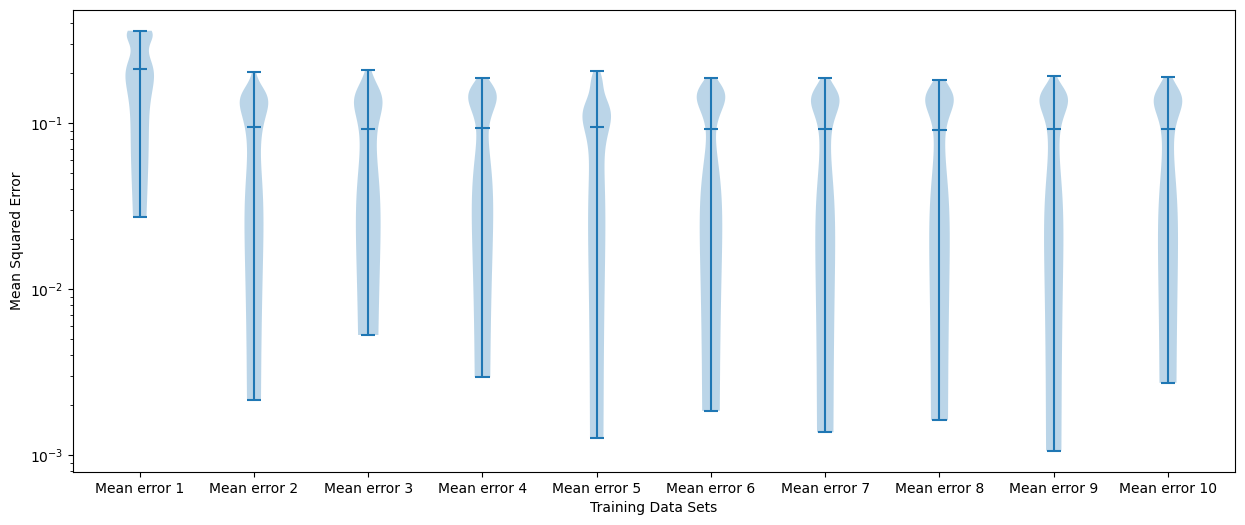

In [52]:
# Sample data
data1 = df_test['mean_error_0']
data2 = df_test['mean_error_1']
data3 = df_test['mean_error_2']
data4 = df_test['mean_error_3']
data5 = df_test['mean_error_4']
data6 = df_test['mean_error_5']
data7 = df_test['mean_error_6']
data8 = df_test['mean_error_7']
data9 = df_test['mean_error_8']
data10 = df_test['mean_error_9']

data = [data1, data2, data3, data4, data5, data6, data7, data8, data9, data10]
positions = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19] # Custom positions for each violin

# Create the plot
fig, ax = plt.subplots(figsize=(15, 6))

# Create violin plots
ax.violinplot(data, positions=positions, showmeans=True)

# Set the x-axis ticks and labels
ax.set_xticks(positions)
ax.set_xticklabels(['Mean error 1', 'Mean error 2', 'Mean error 3', 'Mean error 4', 'Mean error 5', 'Mean error 6', 'Mean error 7', 'Mean error 8', 'Mean error 9', 'Mean error 10'])

# Add labels and title
ax.set_xlabel('Training Data Sets')
ax.set_ylabel('Mean Squared Error')

ax.set_yscale('log')
# Show the plot
plt.show()

Where was the training data distributed? Where were extra points added?


/var/folders/s7/ppvg5_4n3rb1jwlrypfbl4g00000gn/T/ipykernel_14295/2653028089.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/s7/ppvg5_4n3rb1jwlrypfbl4g00000gn/T/ipykernel_14295/2653028089.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/s7/ppvg5_4n3rb1jwlrypfbl4g00000gn/T/ipykernel_14295/2653028089.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/s7/ppvg5_4n3rb1jwlrypfbl4g00000gn/T/ipykernel_14295/2653028089.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/s7/ppvg5_4n3rb1jwlrypfbl4g00000gn/T/ipykernel_14295/2653028089.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/s7/ppvg5_4n3rb1jwlrypfbl4g00000gn/T/ipykernel_14295/2653028089.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/s7/ppvg5_4n3rb1jwlrypfbl4g0

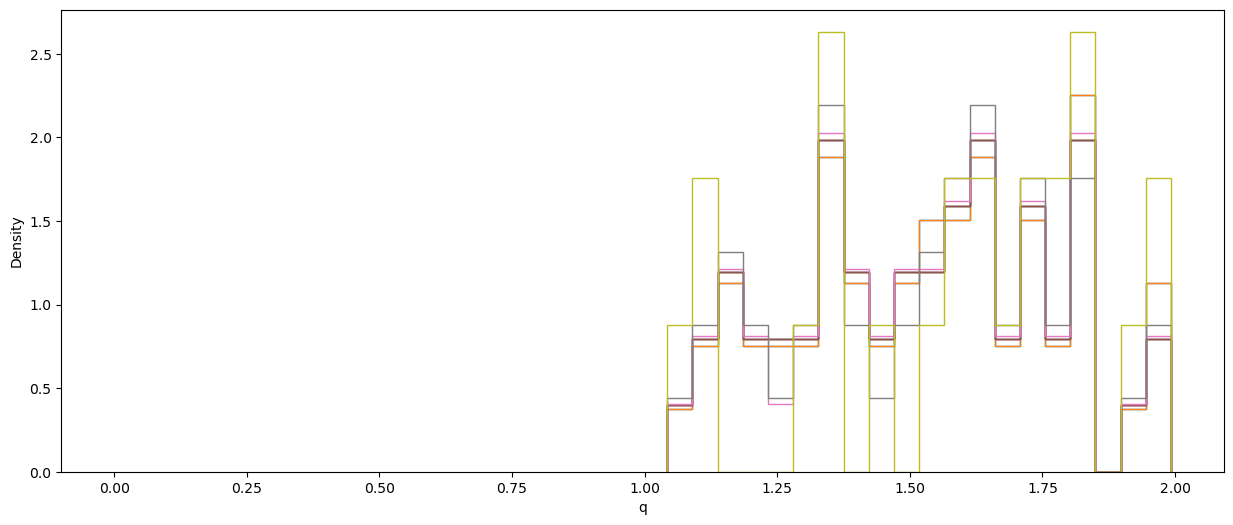

In [53]:
# Sample data
data1 = df_test[df_train['mean_error_0'].notna()]['q']
data2 = df_test[df_train['mean_error_1'].notna()]['q']
data3 = df_test[df_train['mean_error_2'].notna()]['q']
data4 = df_test[df_train['mean_error_3'].notna()]['q']
data5 = df_test[df_train['mean_error_4'].notna()]['q']
data6 = df_test[df_train['mean_error_5'].notna()]['q']
data7 = df_test[df_train['mean_error_6'].notna()]['q']
data8 = df_test[df_train['mean_error_7'].notna()]['q']
data9 = df_test[df_train['mean_error_8'].notna()]['q']
data10 = df_test[df_train['mean_error_9'].notna()]['q']

# Create the plot
fig, ax = plt.subplots(figsize=(15, 6))

# Create violin plots
ax.hist(data1, label='Iteration 0', histtype='step', bins=20, density=True)
ax.hist(data2, label='Iteration 1', histtype='step', bins=20, density=True)
ax.hist(data3, label='Iteration 2', histtype='step', bins=20, density=True)
ax.hist(data4, label='Iteration 3', histtype='step', bins=20, density=True)
ax.hist(data5, label='Iteration 4', histtype='step', bins=20, density=True)
ax.hist(data6, label='Iteration 5', histtype='step', bins=20, density=True)
ax.hist(data7, label='Iteration 6', histtype='step', bins=20, density=True)
ax.hist(data8, label='Iteration 7', histtype='step', bins=20, density=True)
ax.hist(data9, label='Iteration 8', histtype='step', bins=20, density=True)
ax.hist(data10, label='Iteration 9', histtype='step', bins=20, density=True)


# Add labels and title
ax.set_xlabel('q')
ax.set_ylabel('Density')

# Show the plot
plt.show()

## Questions/Notes

How does our final fit compare to the original one at the beginning? Test it out!

Things we did today:

    - Optimised the functional hyperparameters of the neural network
    - Optimised the shape hyperparameters of the neural network
    - Optimised the size and distribution of the training data
Things we did not do:

    - Changing the size of the reduced basis as our iterative training data set grows
    - Optimising the size of the reduced basis for the accuracy we want to achieve
    - Use more complicated neural netwrk architectures or features (learning rate schedulers, other kinds of architectures, hourglass architectures, etc.)
    - Play around with data scaling (normalisation, standardisation, etc.)

What else could we have done to improve our fits?